# Fine-Tuning, Cross-Validation and PBT algorithm for SciBERT

Note: PBT algorithm took awhile to execute on colab pro

All directories have been commented out and marked with a large text cell above where directories need to be replaced

In [ ]:
!pip install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.1 MB/s 


In [ ]:
!pip install datasets seqeval transformers "ray[tune]" scipy sklearn torch

In [ ]:
import torch
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.model_selection import train_test_split
import json
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def tag_creator1(json):
    data_list = json['annotations']
    classes = json['classes']

    store = []
    for sent_ent in data_list:
        store.append((sent_ent[0], sent_ent[1]))
    
    out = []
    for words, ents in store:
        letters = []
        for letter in words:
            letters.append(letter)
        out.append((letters, ents))

    #out = [(['T','o',' ','s'...],{'entities':[[118,132,'MIXED EFFECTS],[...],...]}),(....)]

    all_ranges = []

    for letters_list, entdict in out:
        ranges=[]
        for entpair in entdict['entities']:
            ranges.append((entpair[0],entpair[1],entpair[2]))
        all_ranges.append(ranges) # all_ranges is a list of lists where each sublist contains a tuple [(start_index, end_index, entity)] for each entdict

    for letters_list_entdict_pair in out:
        for ents in letters_list_entdict_pair[1]['entities']:
            start = ents[0]
            end = ents[1]
            ent = ents[2]

            for coded_pair in at_ent_tups:
                if ent == coded_pair[1]:
                    ent = coded_pair[0]

            for i in range(start,end):
                if letters_list_entdict_pair[0][i] != ' ':
                  letters_list_entdict_pair[0][i] = ent

    out2 = []
    
    for letters_list_entdict_pair in out:
        new = ""
        for letter in letters_list_entdict_pair[0]:
            new += letter
        out2.append((new, letters_list_entdict_pair[1]))

    test = ['@0','@1','@2','@3','@4','@5','@6','@7']
    testdict = {}
    for number, cla in zip(test,classes):
        testdict[number] = cla
    #print(testdict)
    #Tokenizing the words in each sentence
    tagslist=[]
    for sent, ents in out2:
        tagslist.append(sent.split(" "))

    #Below reassigns any non entities to 'O' and assigns any entities to 'B -' + the entity type
    for tags in tagslist:
        for i in range(len(tags)):
            if '@0' in tags[i]:
                tags[i] = 'B-' + testdict['@0']
            elif '@1' in tags[i]:
                tags[i] = 'B-' + testdict['@1']
            elif '2@' in tags[i]:
                tags[i] = 'B-' + testdict['@2']
            elif '@3' in tags[i]:
                tags[i] = 'B-' + testdict['@3']
            elif '@4' in tags[i]:
                tags[i] = 'B-' + testdict['@4']
            elif '@5' in tags[i]:
                tags[i] = 'B-' + testdict['@5']
            elif '@6' in tags[i]:
                tags[i] = 'B-' + testdict['@6']
            elif '@7' in tags[i]:
                tags[i] = 'B-' + testdict['@7']
            else:
                tags[i] = 'O'
    #print(tagslist)


    for tags in tagslist:
        for index, elem in enumerate(tags):
            el_minus_1 = tags[index-1]
            el_current = tags[index]
            if el_minus_1.startswith('B') and el_minus_1[-4:].endswith(el_current[-4:]):
                tags[index] = tags[index].replace('B', 'I', 1)
            elif el_minus_1.startswith('I') and el_minus_1[-4:].endswith(el_current[-4:]):
              tags[index] = tags[index].replace('B','I', 1)


    #print(tagslist)
    return tagslist


In [ ]:
def tags_convert2(tag_list):
  out=[]
  for tag in tag_list:
    if tag == 'O':
      out.append(0)
    elif tag == 'B-OLS GLM':
      out.append(1)
    elif tag == 'I-OLS GLM':
      out.append(2)
    elif tag == 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)':
      out.append(3)
    elif tag == 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)':
      out.append(4)
    elif tag == 'B-BAYES FACTOR, BAYESIAN ESTIMATION':
      out.append(5)
    elif tag == 'I-BAYES FACTOR, BAYESIAN ESTIMATION':
      out.append(6)
    elif tag == 'B-NON-PARAMETRIC TESTS':
      out.append(7)
    elif tag == 'I-NON-PARAMETRIC TESTS':
      out.append(8)
    elif tag == 'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)':
      out.append(9)
    elif tag == 'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)':
      out.append(10)
    elif tag == 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA':
      out.append(11)
    elif tag == 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA':
      out.append(12)
    elif tag == 'B-OTHER':
      out.append(13)
    elif tag == 'I-OTHER':
      out.append(14)
    elif tag == 'B-CHI-SQUARE, FISHER EXACT':
      out.append(15)
    elif tag == 'I-CHI-SQUARE, FISHER EXACT':
      out.append(16)
    
  return out

# REPLACE DIRECTORY HERE

In [ ]:
#Will need to replace directory here, order does not matter.
f = open(#"/content/drive/MyDrive/Colab Notebooks/anno_mart.json")
g = open(#"/content/drive/MyDrive/Colab Notebooks/annotations_18_08_2022.json")
h = open(#"/content/drive/MyDrive/Colab Notebooks/annotations_22_08_2022.json")
i = open(#"/content/drive/MyDrive/Colab Notebooks/annotations_27_08_2022.json")
TRAIN_DATA = json.load(f)
TRAIN_DATA1 = json.load(g)
TRAIN_DATA2 = json.load(h)
TRAIN_DATA3 = json.load(i)

In [ ]:
coded_entity_types = list(enumerate(TRAIN_DATA['classes']))
O = [(8, 'O')]
coded_with_O = coded_entity_types + O
coded_with_O

[(0, 'OLS GLM'),
 (1, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 (2, 'BAYES FACTOR, BAYESIAN ESTIMATION'),
 (3, 'NON-PARAMETRIC TESTS'),
 (4, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 (5, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 (6, 'OTHER'),
 (7, 'CHI-SQUARE, FISHER EXACT'),
 (8, 'O')]

In [ ]:
at_ent_tups = []
for i,j in coded_entity_types:
  at_ent_tups.append(('@'+str(i),j))

at_ent_tups

[('@0', 'OLS GLM'),
 ('@1', 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 ('@2', 'BAYES FACTOR, BAYESIAN ESTIMATION'),
 ('@3', 'NON-PARAMETRIC TESTS'),
 ('@4',
  'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 ('@5', 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 ('@6', 'OTHER'),
 ('@7', 'CHI-SQUARE, FISHER EXACT')]

In [ ]:
label_list=[]
label_list.append("O")
for num,ent in coded_entity_types:
  label_list.append("B-"+ent)
  label_list.append("I-"+ent)
label_list

['O',
 'B-OLS GLM',
 'I-OLS GLM',
 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)',
 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)',
 'B-BAYES FACTOR, BAYESIAN ESTIMATION',
 'I-BAYES FACTOR, BAYESIAN ESTIMATION',
 'B-NON-PARAMETRIC TESTS',
 'I-NON-PARAMETRIC TESTS',
 'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)',
 'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)',
 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA',
 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA',
 'B-OTHER',
 'I-OTHER',
 'B-CHI-SQUARE, FISHER EXACT',
 'I-CHI-SQUARE, FISHER EXACT']

In [ ]:
full_ent_codes = list(enumerate(label_list))
full_ent_codes

[(0, 'O'),
 (1, 'B-OLS GLM'),
 (2, 'I-OLS GLM'),
 (3, 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 (4, 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 (5, 'B-BAYES FACTOR, BAYESIAN ESTIMATION'),
 (6, 'I-BAYES FACTOR, BAYESIAN ESTIMATION'),
 (7, 'B-NON-PARAMETRIC TESTS'),
 (8, 'I-NON-PARAMETRIC TESTS'),
 (9,
  'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 (10,
  'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 (11, 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 (12, 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 (13, 'B-OTHER'),
 (14, 'I-OTHER'),
 (15, 'B-CHI-SQUARE, FISHER EXACT'),
 (16, 'I-CHI-SQUARE, FISHER EXACT')]

# **REPLACE DIRECTORY HERE** - for each dataframe assign the directory of one of the JSON's, order does not matter.

In [ ]:
df = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/anno_mart.json", orient='index' )
df = df.iloc[1]
sentences=[]
entity_dicts=[]
for i in df:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

df = pd.DataFrame(new)
df.head()

,sentences,entities
0,To explore longitudinal trends in cognitive ab...,"{'entities': [[126, 157, 'MIXED EFFECTS, MLMS,..."
1,Regression slopes for all groups did not reach...,"{'entities': [[0, 17, 'OLS GLM']]}"
2,"Within these analyses, the percent of particip...","{'entities': [[210, 226, 'CHI-SQUARE, FISHER E..."
3,Statistical differences across outcome groups ...,"{'entities': [[68, 104, 'OLS GLM'], [109, 141,..."
4,Because the population distribution of RVC is ...,"{'entities': [[81, 100, 'NON-PARAMETRIC TESTS']]}"


In [ ]:
dfx = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/annotations_18_08_2022.json", orient='index')
dfx = dfx.iloc[1]
sentences=[]
entity_dicts=[]
for i in dfx:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

dfx = pd.DataFrame(new)
dfx.tail()

,sentences,entities
98,"For any other MHP, the logistic regression mod...","{'entities': [[23, 48, 'MIXED EFFECTS, MLMS, G..."
99,Cox regression was used to compare the risk of...,"{'entities': [[0, 14, 'MIXED EFFECTS, MLMS, GR..."
100,The differences between this group and the sta...,"{'entities': [[115, 136, 'NON-PARAMETRIC TESTS..."
101,"This subscale included three items namely, “su...",{'entities': []}
102,Descriptive analysis involved means and standa...,"{'entities': [[84, 112, 'OLS GLM']]}"


In [ ]:
dfy = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/annotations_22_08_2022.json", orient='index')
dfy = dfy.iloc[1]
sentences=[]
entity_dicts=[]
for i in dfy:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

dfy = pd.DataFrame(new)
dfy.tail()

,sentences,entities
87,We followed an iterative process to build the ...,"{'entities': [[46, 66, 'MIXED EFFECTS, MLMS, G..."
88,Adolescent sex was included in all hierarchica...,"{'entities': [[35, 67, 'OLS GLM'], [72, 104, '..."
89,The pre-treatment score for the outcome variab...,"{'entities': [[72, 91, 'OLS GLM'], [126, 150, ..."
90,Logistic regression analyses were conducted to...,"{'entities': [[0, 28, 'MIXED EFFECTS, MLMS, GR..."
91,A chi-square analysis revealed that the differ...,"{'entities': [[2, 21, 'CHI-SQUARE, FISHER EXAC..."


In [ ]:
dfz = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/annotations_27_08_2022.json", orient='index')
dfz = dfz.iloc[1]
sentences=[]
entity_dicts=[]
for i in dfz:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

dfz = pd.DataFrame(new)
dfz.tail()

,sentences,entities
297,"n the current study, a new 2-factor analysis o...","{'entities': [[27, 44, 'SCALE DEVELOPMENT, FAC..."
298,"A series of analyses of variance, discriminant...","{'entities': [[12, 32, 'OLS GLM'], [34, 64, 'S..."
299,"Moreover, results of factor and discriminant f...","{'entities': [[32, 62, 'SCALE DEVELOPMENT, FAC..."
300,All symptom items for both disorders were ente...,"{'entities': [[57, 72, 'SCALE DEVELOPMENT, FAC..."
301,"Similarly, when entered into a factor analysis...","{'entities': [[31, 46, 'SCALE DEVELOPMENT, FAC..."


In [ ]:
df = pd.concat([df,dfx,dfy,dfz],ignore_index=True)
df

,sentences,entities
0,To explore longitudinal trends in cognitive ab...,"{'entities': [[126, 157, 'MIXED EFFECTS, MLMS,..."
1,Regression slopes for all groups did not reach...,"{'entities': [[0, 17, 'OLS GLM']]}"
2,"Within these analyses, the percent of particip...","{'entities': [[210, 226, 'CHI-SQUARE, FISHER E..."
3,Statistical differences across outcome groups ...,"{'entities': [[68, 104, 'OLS GLM'], [109, 141,..."
4,Because the population distribution of RVC is ...,"{'entities': [[81, 100, 'NON-PARAMETRIC TESTS']]}"
...,...,...
629,Some discussion of the relationship between ne...,{'entities': []}
630,The results from the conditional fixed effects...,{'entities': []}
631,We were concerned with four relations (Table 1...,{'entities': []}
632,The ethics committee at Humboldt-University of...,{'entities': []}


In [ ]:
tags = tag_creator1(TRAIN_DATA)
tagsx = tag_creator1(TRAIN_DATA1)
tagsy = tag_creator1(TRAIN_DATA2)
tagsz = tag_creator1(TRAIN_DATA3)
tags1 = []
for i in tags:
  tags1.append(tags_convert2(i))

for i in tagsx:
  tags1.append(tags_convert2(i))

for i in tagsy:
  tags1.append(tags_convert2(i))

for i in tagsz:
  tags1.append(tags_convert2(i))

In [ ]:
sentence_taglist_dict = {}
for sent, tags in zip(df['sentences'],tags1):
  sentence_taglist_dict[sent] = tags

In [ ]:
def label(row):
  for i in df['sentences']:
      if row == i:
        return sentence_taglist_dict[i]

In [ ]:
df['Coded'] = df['sentences'].apply(lambda row: label(row))

In [ ]:
df['sentences'] = df['sentences'].apply(lambda row: row.split(" "))
df

,sentences,entities,Coded
0,"[To, explore, longitudinal, trends, in, cognit...","{'entities': [[126, 157, 'MIXED EFFECTS, MLMS,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Regression, slopes, for, all, groups, did, no...","{'entities': [[0, 17, 'OLS GLM']]}","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Within, these, analyses,, the, percent, of, p...","{'entities': [[210, 226, 'CHI-SQUARE, FISHER E...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Statistical, differences, across, outcome, gr...","{'entities': [[68, 104, 'OLS GLM'], [109, 141,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 15,..."
4,"[Because, the, population, distribution, of, R...","{'entities': [[81, 100, 'NON-PARAMETRIC TESTS']]}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, ..."
...,...,...,...
629,"[Some, discussion, of, the, relationship, betw...",{'entities': []},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
630,"[The, results, from, the, conditional, fixed, ...",{'entities': []},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
631,"[We, were, concerned, with, four, relations, (...",{'entities': []},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
632,"[The, ethics, committee, at, Humboldt-Universi...",{'entities': []},"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df = df.drop('entities',axis=1)

In [ ]:
df = df.rename(columns={"sentences": "Sentences"})
df

,Sentences,Coded
0,"[To, explore, longitudinal, trends, in, cognit...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Regression, slopes, for, all, groups, did, no...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Within, these, analyses,, the, percent, of, p...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Statistical, differences, across, outcome, gr...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 15,..."
4,"[Because, the, population, distribution, of, R...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, ..."
...,...,...
629,"[Some, discussion, of, the, relationship, betw...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
630,"[The, results, from, the, conditional, fixed, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
631,"[We, were, concerned, with, four, relations, (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
632,"[The, ethics, committee, at, Humboldt-Universi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
ds = Dataset.from_pandas(df).train_test_split(test_size=0.2)
ds

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'Coded'],
        num_rows: 507
    })
    test: Dataset({
        features: ['Sentences', 'Coded'],
        num_rows: 127
    })
})

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [ ]:
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["Sentences"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["Coded"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = ds.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
batch_size=8

args = TrainingArguments(
    "scibert-finetune",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_steps=1
)

data_collator = DataCollatorForTokenClassification(tokenizer)

metric = load_metric("seqeval")

In [ ]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=len(label_list))

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    model_init = model_init
)

/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:350: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  FutureWarning,


#PBT

In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune import CLIReporter
from ray.tune import JupyterNotebookReporter

In [ ]:
tune_config = {
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 32,
    "num_train_epochs": tune.choice([10, 15]),
    #"max_steps": 1 if smoke_test else -1,  # Used for smoke test.
}

In [ ]:
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="eval_f1",
    mode="max",
    perturbation_interval=1,
    hyperparam_mutations={
      "weight_decay": tune.uniform(0.0, 0.3), 
      "learning_rate": tune.uniform(1e-5, 5e-5),
      "per_device_train_batch_size": [16, 32, 64]
    }
)

In [ ]:
reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs",
    },
    metric_columns=["eval_f1", "eval_loss", "epoch"]
)

In [ ]:
hpsearch = trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=5, # number of trials
    scheduler=scheduler,
    resources_per_trial={"cpu": 2, "gpu": 1},
    keep_checkpoints_num=1,
    checkpoint_score_attr="training_iteration",
    progress_reporter=reporter,
    reuse_actors=True,
    local_dir="/content/drive/MyDrive/Colab Notebooks/",
    name="tune_transformer_pbt_scibert",
    log_to_file=True,
    resume=True
)

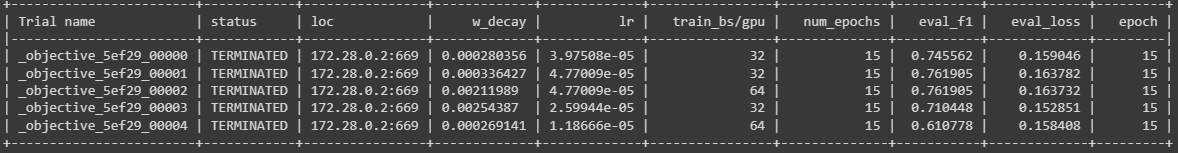

In [ ]:
hpsearch

BestRun(run_id='5ef29_00004', objective=2.8021571679730215, hyperparameters={'per_device_train_batch_size': 64, 'per_device_eval_batch_size': 32, 'num_train_epochs': 15, 'weight_decay': 0.0002691414746545518, 'learning_rate': 1.1866626528544617e-05})

best f1 lr = 4.77009e-05, weight decay = 0.000336427, batch size= 32

In [ ]:
#4-Fold psuedo CV
ds1 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=1)
ds2 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=2)
ds3 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=3)
ds4 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=4)
tds1 = ds1.map(tokenize_and_align_labels, batched=True)
tds2 = ds2.map(tokenize_and_align_labels, batched=True)
tds3 = ds3.map(tokenize_and_align_labels, batched=True)
tds4 = ds4.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
args = TrainingArguments(
    "scibert-finetune",
    evaluation_strategy = "epoch",
    learning_rate=4.77009e-05,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.000336427,
    logging_steps=1   
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


#Cross Validation

In [ ]:
#Fold 1
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds1["train"],
    eval_dataset=tds1["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds1["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold1 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold1)

#Fold 2
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds2["train"],
    eval_dataset=tds2["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds2["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold2 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold2)

#Fold 3
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds3["train"],
    eval_dataset=tds3["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds3["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold3 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold3)
#Fold 4
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds4["train"],
    eval_dataset=tds4["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds4["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold4 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold4)

In [ ]:
print(results_fold1)
print(results_fold2)
print(results_fold3)
print(results_fold4)

{'CHI-SQUARE, FISHER EXACT': {'precision': 0.5454545454545454, 'recall': 0.5, 'f1': 0.5217391304347826, 'number': 12}, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.5833333333333334, 'recall': 0.7777777777777778, 'f1': 0.6666666666666666, 'number': 9}, 'NON-PARAMETRIC TESTS': {'precision': 0.5882352941176471, 'recall': 0.9090909090909091, 'f1': 0.7142857142857143, 'number': 22}, 'OLS GLM': {'precision': 0.6451612903225806, 'recall': 0.7894736842105263, 'f1': 0.7100591715976331, 'number': 76}, 'OTHER': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 2}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.45454545454545453, 'recall': 0.4166666666666667, 'f1': 0.43478260869565216, 'number': 12}, 'overall_precision': 0.6086956521739131, 'overall_recall': 0.7368421052631579, 'overall_f1': 0.6666666666666666, 'overall_accuracy': 0.9681394649834686}
{'CHI-SQUARE, FISHER EXACT': {'precision': 1.0, 'recall': 0.6, 'f1': 0.7499999999999999, 'num

In [ ]:
folds = [results_fold1, results_fold2, results_fold3, results_fold4]
CV_F1S = [i['overall_f1'] for i in folds]
CV_P = [i['overall_precision'] for i in folds]
CV_R = [i['overall_recall'] for i in folds]

print("Mean F1 across folds: {}".format(np.mean(CV_F1S)))
print("F1 Std across folds: {}".format(np.std(CV_F1S)))
print("Mean Precision across folds: {}".format(np.mean(CV_P)))
print("Precision Std across folds: {}".format(np.std(CV_P)))
print("Mean Recall across folds: {}".format(np.mean(CV_R)))
print("Recall Std across folds: {}".format(np.std(CV_R)))

Mean F1 across folds: 0.6246910664908001
F1 Std across folds: 0.026504506271222163
Mean Precision across folds: 0.6025503912400784
Precision Std across folds: 0.026982283907344067
Mean Recall across folds: 0.6530524282781422
Recall Std across folds: 0.05943296046405479


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
results

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/scibert_cased-finetune")